<a href="https://colab.research.google.com/github/slkanthi/MelonamaDetection/blob/main/SreeLakshmiKanthi_Singamsetty_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#library imports
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [3]:
# Defining the path for train and test images
train_dir = "/content/drive/MyDrive/CNN_MelonamaDetectionAssignment_Images/Train"
test_dir = "/content/drive/MyDrive/CNN_MelonamaDetectionAssignment_Images/Test"

In [4]:
# Counting the images in the dataset
image_count_train = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(test_dir).glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
class_names = os.listdir(train_dir)
class_names

['vascular lesion',
 'basal cell carcinoma',
 'melanoma',
 'actinic keratosis',
 'squamous cell carcinoma',
 'dermatofibroma',
 'pigmented benign keratosis',
 'nevus',
 'seborrheic keratosis']

Load using keras.preprocessing.
Let's load these images off disk using the helpful image_dataset_from_directory utility.
Use 80% of the images for training, and 20% for validation.

In [6]:
#Data processing by setting the hyper parameters
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width), label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


Dataset visualisation

Code to visualize all the nine classes present in the dataset

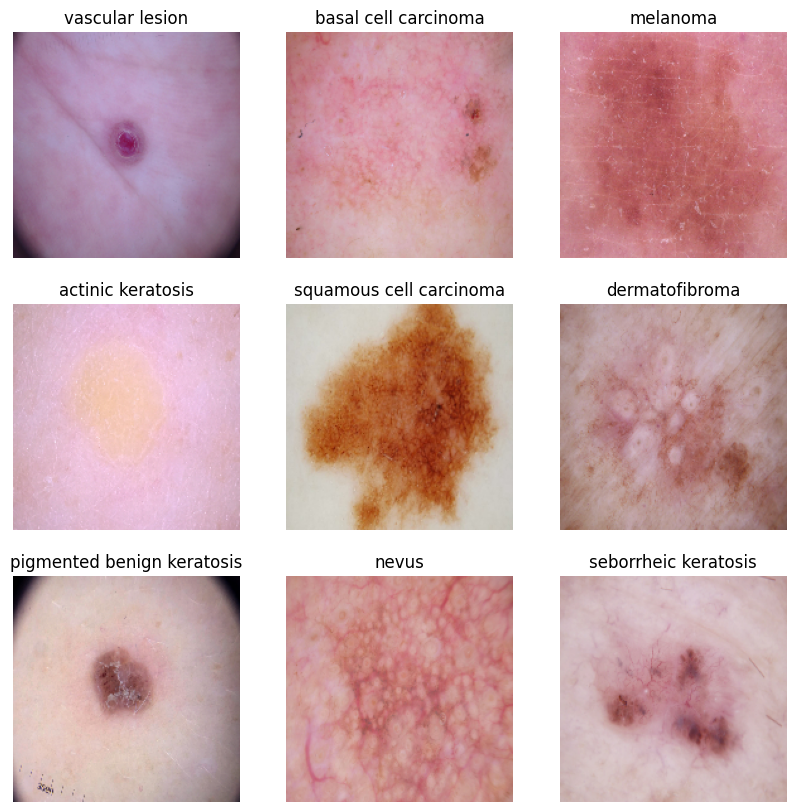

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

Let us see How many images are available for each class

In [10]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,vascular lesion,139
1,basal cell carcinoma,376
2,melanoma,438
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,dermatofibroma,95
6,pigmented benign keratosis,462
7,nevus,357
8,seborrheic keratosis,77


In [11]:
count= []
for path in pathlib.Path(test_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, name))]

#return dataframe with image count and class.
df_test= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No. of Images in test dir'])
df_test

,Class_Name,No. of Images in test dir
0,vascular lesion,3
1,nevus,16
2,pigmented benign keratosis,16
3,squamous cell carcinoma,16
4,seborrheic keratosis,3
5,dermatofibroma,16
6,actinic keratosis,16
7,melanoma,16
8,basal cell carcinoma,16


<Axes: xlabel='No. of Images in test dir', ylabel='Class_Name'>

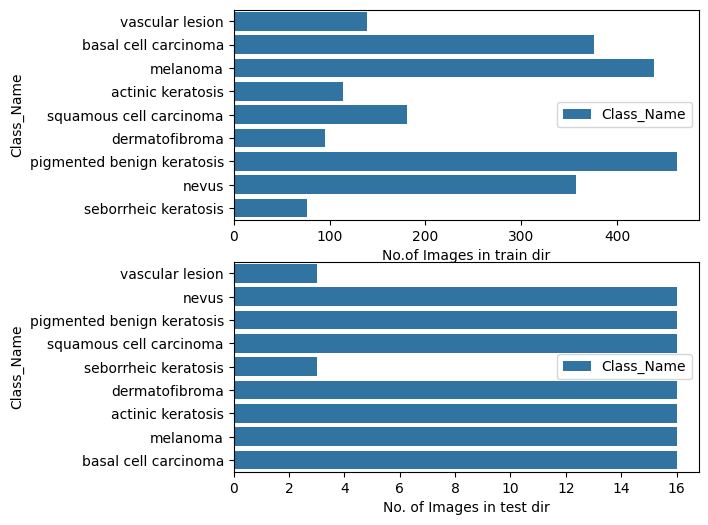

In [12]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class_Name")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
#  The RGB channel values are in the [0, 255] range.Rescaling to normalize pixel values between (0,1).
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (Batch  (None, 83, 83, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 64)        0

In [15]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [16]:
epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[earlystop])

Epoch 1/20
56/56 [==============================] - 632s 7s/step - loss: 22.5007 - accuracy: 0.2829 - val_loss: 15.4919 - val_accuracy: 0.1119
Epoch 2/20
56/56 [==============================] - 289s 5s/step - loss: 10.8678 - accuracy: 0.3259 - val_loss: 7.9087 - val_accuracy: 0.0872
Epoch 3/20
56/56 [==============================] - 294s 5s/step - loss: 3.7645 - accuracy: 0.2824 - val_loss: 14.7354 - val_accuracy: 0.0872
Epoch 4/20
56/56 [==============================] - 290s 5s/step - loss: 2.4636 - accuracy: 0.3164 - val_loss: 12.1068 - val_accuracy: 0.0872
Epoch 5/20
56/56 [==============================] - 291s 5s/step - loss: 2.2096 - accuracy: 0.3666 - val_loss: 4.8105 - val_accuracy: 0.0895
Epoch 6/20
56/56 [==============================] - 291s 5s/step - loss: 2.0464 - accuracy: 0.4007 - val_loss: 4.2915 - val_accuracy: 0.1186
Epoch 7/20
56/56 [==============================] - 291s 5s/step - loss: 1.7830 - accuracy: 0.4431 - val_loss: 2.7411 - val_accuracy: 0.2483
Epoch 8/

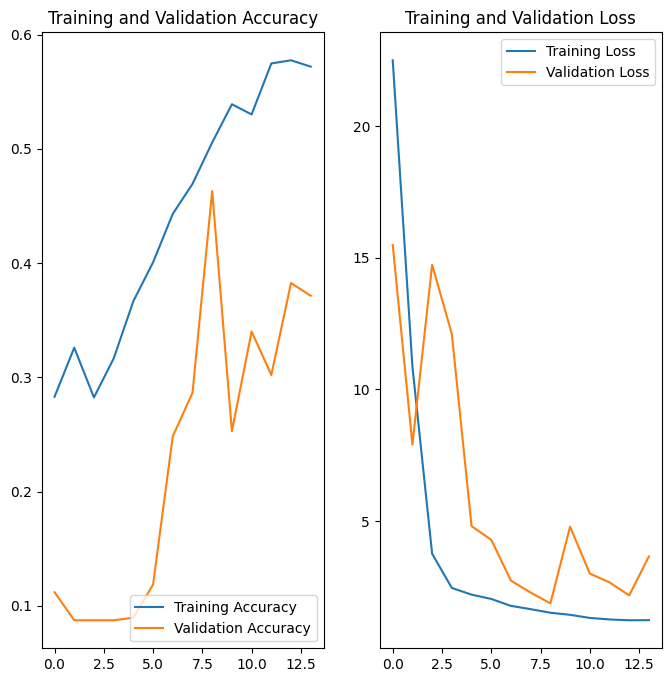

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 14
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()